In [2]:
import rsf.api as sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import seaborn as sns

%matplotlib inline

#sns.set_style('ticks')

# Read and QC final processed SEG-Y (1981)

We will convert to SEG-Y and QC data and header from the final (1981) processed line.

In [3]:
!sfsegyread < final_processed_1981.sgy tfile=final_processed_1981_header.rsf hfile=text_header.txt > final_processed_1981.rsf

In [6]:
!cat text_header.txt | fold -w 80

C01 CLIENT/JOB ID    1 1 2 9 2 1 1 3                                            
C02 LINE    L31                                                                 
C03 REEL NO 810602112911   DAY-START OF REEL  02       YEAR 1981                
C04 INSTRUMENT: MFG TI          MODEL ASC                                       
C05 DATA TRACES/RECORD0001      AUXILIARY TRACES/RECORD 0       CDP FOLD  0001  
C06 SAMPLE RATE   0000004000 US  SAMPLES/TRACE  1501BITS/IN 1600 BYTES/SAMPLE 4 
C07 RECORDING FORMAT  STDI              FORMAT THIS REEL SEG Y1                 
C08 SAMPLE CODE: FLOATING PT 4 BYTE                                             
C09 GAIN TYPE:   FLOATING PT                                                    
C10                                                                             
C11                                                                             
C12                                                                             
C13                         

In [4]:
!sfheaderattr < final_processed_1981_header.rsf

91 headers, 534 traces
******************************************************************************* 
     key     	            min     	              max    	          mean
------------------------------------------------------------------------------- 
tracl       0              1 @ 0	           534 @ 533	         267.5
tracr       1              1 @ 0	           534 @ 533	         267.5
fldr        2            111 @ 0	           167 @ 440	        143.24
cdp         5            101 @ 0	           634 @ 533	         367.5
cdpt        6              1 @ 0	             1 @ 0	             1
trid        7              1 @ 0	             1 @ 0	             1
nvs         8              1 @ 0	             1 @ 0	             1
nhs         9              1 @ 0	            12 @ 88	       9.94757
duse       10              1 @ 0	             1 @ 0	             1
scalco     20              1 @ 0	             1 @ 0	             1
ns         38           1501 @ 0	          1501 @ 0	          15

In [21]:
!sfdd type=float < final_processed_1981_header.rsf > final_header_float.rsf

In [23]:
keys = {'tracl': 0, 'tracr': 1, 'fldr': 2,
    'cdp': 5,'cdpt': 6,
    'trid': 7, 'nvs': 8,
    'nhs': 9, 'duse': 10,
    'scalco': 20, 'ns': 38,
    'dt': 39, 'timbas': 64,
    'trwf': 65, 'cdpx': 71,
    'cdpy': 72, 'tval': 77,
    'tconst4': 78}

In [22]:
header = sf.Input('final_header_float.rsf')
n1 = header.int('n1')
n2 = header.int('n2')

header_data = np.zeros((n2,n1), dtype=np.float32)
header.read(header_data)

header_data

array([[  1.,   1., 111., ...,   0.,   0.,   0.],
       [  2.,   2., 111., ...,   0.,   0.,   0.],
       [  3.,   3., 111., ...,   0.,   0.,   0.],
       ...,
       [532., 532., 167., ...,   0.,   0.,   0.],
       [533., 533., 167., ...,   0.,   0.,   0.],
       [534., 534., 167., ...,   0.,   0.,   0.]], dtype=float32)

In [27]:
header_data.shape

(534, 91)

In [31]:
df = {}

for key in keys:
    df[key] = header_data[:, keys[key]]

df = pd.DataFrame(df)
df.head()

,cdp,cdpt,cdpx,cdpy,dt,duse,fldr,nhs,ns,nvs,scalco,tconst4,timbas,tracl,tracr,trid,trwf,tval
0,101.0,1.0,6000.0,65536.0,4000.0,1.0,111.0,1.0,1501.0,1.0,1.0,10000.0,1.0,1.0,1.0,1.0,10.0,34.0
1,102.0,1.0,6000.0,65536.0,4000.0,1.0,111.0,1.0,1501.0,1.0,1.0,10000.0,1.0,2.0,2.0,1.0,10.0,34.0
2,103.0,1.0,6000.0,65536.0,4000.0,1.0,111.0,1.0,1501.0,1.0,1.0,10000.0,1.0,3.0,3.0,1.0,10.0,36.0
3,104.0,1.0,6000.0,65536.0,4000.0,1.0,111.0,1.0,1501.0,1.0,1.0,10000.0,1.0,4.0,4.0,1.0,10.0,35.0
4,105.0,1.0,6000.0,65536.0,4000.0,1.0,111.0,1.0,1501.0,1.0,1.0,10000.0,1.0,5.0,5.0,1.0,10.0,36.0


CDP spacing:  [nan  1.]


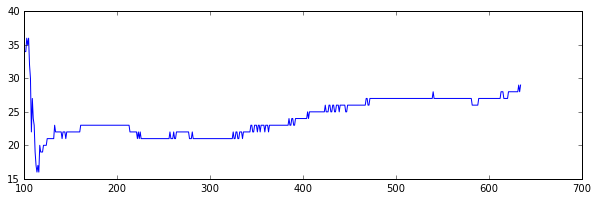

In [57]:
print "CDP spacing: ", df.cdp.diff().unique() # Check if CDP spacing is constant
plt.figure(figsize=(10,3))
plt.plot(df.cdp, df.tval)

In [36]:
import matplotlib.gridspec as gridspec

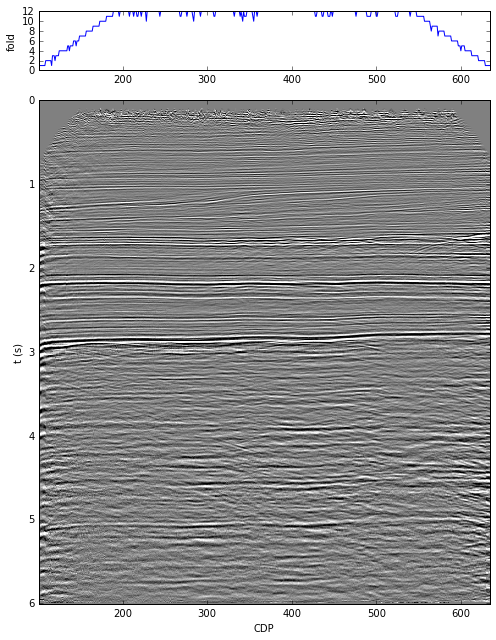

In [67]:
final = sf.Input('final_processed_1981.rsf')
n1 = final.int('n1')
n2 = final.int('n2')
d1 = final.float('d1')

data = np.zeros((n2,n1), dtype=np.float32)
extent = [df.cdp.min(), df.cdp.max(), n1*d1, 0]
final.read(data)

perc = np.percentile(data.ravel(), 99)

plt.figure(figsize=(7,9))
gs = gridspec.GridSpec(7, 1)

ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1:, :], sharex=ax1)

ax1.plot(df.cdp, df.nhs)
ax1.set_ylabel('fold')

ax2.imshow(data.T, vmin=-perc, vmax=perc, cmap='gray', aspect='auto',
          extent=extent)
ax2.set_ylabel('t (s)')
ax2.set_xlabel('CDP')

plt.tight_layout()

# Read and QC Karl's navigation data

In [71]:
!head -15 published_workflow_su/spnElev.txt

88	80.5
89	80.7
90	80.5
91	81.2
92	81.6
93	82.4
94	84.2
95	83.7
96	84
97	84.1
98	87.8
99	92.6
100	99.8
106	100.6
113	103.6


In [70]:
!head published_workflow_su/spnXY.txt

In [73]:
nav = pd.read_csv('published_workflow_su/spnXY.txt', sep='\s+',
                  names=['year', 'line', 'ep', 'lat', 'long', 'sx', 'sy'])
nav

,year,line,ep,lat,long,sx,sy
0,1981,31-81,100,70.134322,-151.213349,107575.318015,2.241817e+06
1,1981,31-81,101,70.133654,-151.216283,107465.189195,2.241739e+06
2,1981,31-81,102,70.132984,-151.219224,107354.792805,2.241661e+06
3,1981,31-81,103,70.132313,-151.222158,107244.664392,2.241583e+06
4,1981,31-81,104,70.131646,-151.225099,107134.240872,2.241505e+06
5,1981,31-81,105,70.130975,-151.228032,107024.137674,2.241427e+06
6,1981,31-81,106,70.130305,-151.230973,106913.714513,2.241349e+06
7,1981,31-81,107,70.129637,-151.233906,106803.584241,2.241271e+06
8,1981,31-81,108,70.128966,-151.236838,106693.499578,2.241193e+06
9,1981,31-81,109,70.128298,-151.239771,106583.355973,2.241115e+06
